# KNN

### Single Data Set Run
(3 varaibales Lat, Long and Precipitation Value)

Data set Creation 

In [41]:
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the shapefile
input_shapefile = 'UK_PPT_DEM_12km.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Determine the number of coastal points to delete (10%)
num_to_delete = int(len(coastal_points) * 0.15)

# Randomly select 10% of the coastal points
coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=450)

# Create a training dataset by dropping the selected coastal points
training_data = gdf.drop(coastal_to_delete.index)

# Save the training dataset to a new shapefile
training_shapefile = 'training_data.shp'
training_data.to_file(training_shapefile)

# Save the deleted coastal points to a new shapefile for imputation
imputation_shapefile = 'imputation_data.shp'
coastal_to_delete.to_file(imputation_shapefile)

print(f"Training data saved to: {training_shapefile}")
print(f"Imputation data saved to: {imputation_shapefile}")


Training data saved to: training_data.shp
Imputation data saved to: imputation_data.shp


Running KNN 

k=2, MSE=0.2755591688347479
k=3, MSE=0.4627713170111953
Imputed shapefile saved successfully: imputed_file2.shp


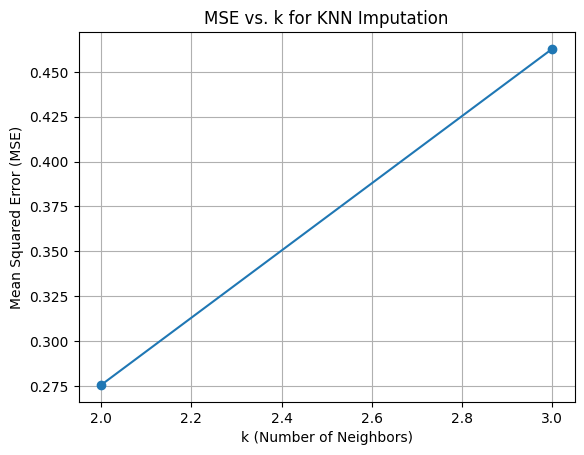

In [47]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the shapefiles
file1 = 'imputation_data.shp'  # Imputation points with missing values
file2 = 'training_data.shp'  # Reference data

gdf1 = gpd.read_file(file1)
gdf2 = gpd.read_file(file2)

'''
# Ensure the datasets are aligned based on coordinates (longitude and latitude)
gdf1['longitude'] = gdf1.geometry.x
gdf1['latitude'] = gdf1.geometry.y
gdf2['longitude'] = gdf2.geometry.x
gdf2['latitude'] = gdf2.geometry.y
'''
# Extract relevant columns for imputation
df1 = gdf1[['longitude', 'latitude', 'value']]
df2 = gdf2[['longitude', 'latitude', 'value']]

# Prepare the KNN regressor
def impute_knn(df_missing, df_reference, k):
    # Fit the KNN regressor on the reference data
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_reference[['longitude', 'latitude']], df_reference['value'])

    # Predict the missing values
    imputed_values = knn.predict(df_missing[['longitude', 'latitude']])
    return imputed_values

# Define the range of k values to test
k_values = range(2,4)
mse_values = []

# Perform KNN imputation and calculate MSE for each k
for k in k_values:
    imputed_values = impute_knn(df1, df2, k)
    mse = mean_squared_error(df1['value'], imputed_values)
    mse_values.append(mse)
    print(f'k={k}, MSE={mse}')

    # Add the imputed values to the original GeoDataFrame
    gdf1[f'imp_val_{k}'] = imputed_values

# Save the modified GeoDataFrame to a new shapefile
output_shapefile = 'imputed_file2.shp'
gdf1.to_file(output_shapefile)
print(f"Imputed shapefile saved successfully: {output_shapefile}")

# Plot MSE values
plt.plot(k_values, mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. k for KNN Imputation')
plt.grid(True)
plt.show()

### Simulating Multiple Data Sets 

(3 Varaibles Lat, Long and Precipitation)

Adding DEM component to KNN 

Processing Runs: 100%|██████████| 10000/10000 [05:24<00:00, 30.86it/s]


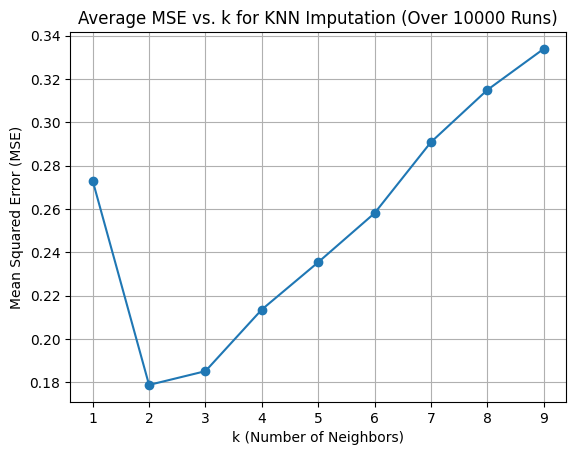

[0.27306453 0.17883076 0.18518091 0.21361391 0.23543776 0.2580857
 0.29086614 0.31495918 0.3339275 ]
Average MSE results saved successfully: average_mse_results_ppt.csv


In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the shapefile
input_shapefile = 'classified_squares_sides_7.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Function to perform KNN imputation and calculate MSE
def perform_imputation(random_state):
    # Determine the number of coastal points to delete (15%)
    num_to_delete = int(len(coastal_points) * 0.15)

    # Randomly select 30% of the coastal points
    coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=random_state)

    # Create a training dataset by dropping the selected coastal points
    training_data = gdf.drop(coastal_to_delete.index)

    # Prepare the datasets for KNN
    gdf1 = coastal_to_delete.copy()
    gdf2 = training_data.copy()
    # Extract relevant columns for imputation
    df1 = gdf1[['longitude', 'latitude', 'value']]
    df2 = gdf2[['longitude', 'latitude', 'value']]

    # Define the range of k values to test
    k_values = range(1, 10)  # Ensuring this matches in both functions
    mse_values = np.zeros(len(k_values))  # Initialize an array to store MSE for each k

    # Perform KNN imputation and calculate MSE for each k
    for idx, k in enumerate(k_values):
        imputed_values = impute_knn(df1, df2, k)
        mse = mean_squared_error(df1['value'], imputed_values)
        mse_values[idx] += mse  # Sum the MSE values

    return mse_values

# Prepare the KNN regressor function
def impute_knn(df_missing, df_reference, k):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_reference[['longitude', 'latitude']], df_reference['value'])
    imputed_values = knn.predict(df_missing[['longitude', 'latitude']])
    return imputed_values

# Number of iterations with different random states
num_iterations = 10000
k_values = range(1, 10)  # Define the k values
cumulative_mse_values = np.zeros(len(k_values))  # Initialize an array to store cumulative MSE

# Perform imputation for different random states and collect MSE values
for i in tqdm(range(num_iterations), desc="Processing Runs"):
    # Generate a random seed value for additional randomness
    random_seed = random.randint(0, 100000)
    random_state = (i * 2 )+ random_seed
    mse_values = perform_imputation(random_state=random_state)
    cumulative_mse_values += mse_values

# Calculate the average MSE for each k value
average_mse_values = cumulative_mse_values / num_iterations

# Plot average MSE values
plt.plot(k_values, average_mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'Average MSE vs. k for KNN Imputation (Over {num_iterations} Runs)')
plt.grid(True)
plt.show()

# Save the results
results = pd.DataFrame({
    'k': k_values,
    'average_mse': average_mse_values
})
print(average_mse_values)
results.to_csv('average_mse_results_ppt.csv', index=False)
print(f"Average MSE results saved successfully: average_mse_results_ppt.csv")

Creating a merged dataset 4 variables lat, long, value ,DEM

In [7]:
import geopandas as gpd
from shapely.geometry import Polygon

# Read the shapefiles
file1 = gpd.read_file('UK_DEM_12km.shp')
file2 = gpd.read_file('classified_squares_sides_7.shp')

# Merge the shapefiles on common fields
# Assuming 'latitude', 'longitude', 'x_min', 'x_max', 'y_min', 'y_max' are the common fields
merged = file1.merge(file2, on=['latitude', 'longitude', 'x_min', 'x_max', 'y_min', 'y_max'])

# Function to create a Polygon from xmin, xmax, ymin, ymax
def create_polygon(row):
    return Polygon([
        (row['x_min'], row['y_min']),
        (row['x_max'], row['y_min']),
        (row['x_max'], row['y_max']),
        (row['x_min'], row['y_max']),
        (row['x_min'], row['y_min'])
    ])

# Create a new 'geometry' column with polygons
merged['geometry'] = merged.apply(create_polygon, axis=1)

# Select the necessary columns
combined = merged[['latitude', 'longitude', 'x_min', 'x_max', 'y_min', 'y_max', 'value_y', 'average_de', 'classifica', 'geometry']]

# Rename 'value_y' to 'value' if needed
combined.rename(columns={'value_y': 'value'}, inplace=True)

# Remove rows where 'average_de' is NaN
combined = combined.dropna(subset=['average_de'])

# Convert to GeoDataFrame
combined = gpd.GeoDataFrame(combined, geometry='geometry')
combined.crs = file1.crs

# Save the new combined dataset to a new shapefile
combined.to_file('UK_PPT_DEM_12km.shp')


C:\Users\vibhu\AppData\Local\Temp\ipykernel_19220\2793015090.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined.rename(columns={'value_y': 'value'}, inplace=True)


Processing Runs: 100%|██████████| 10000/10000 [05:40<00:00, 29.34it/s]


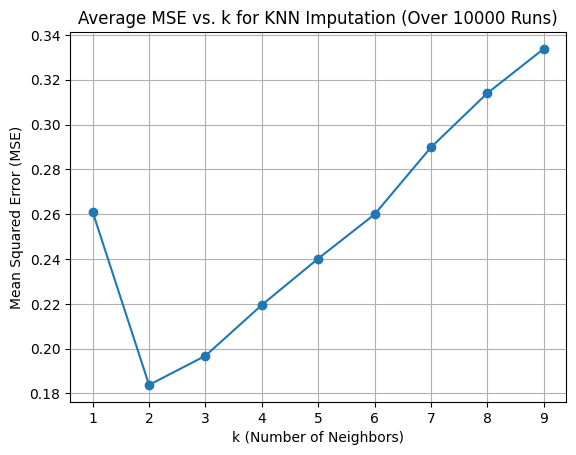

[0.2609748  0.18381959 0.19680886 0.21948605 0.24017893 0.25990167
 0.2897899  0.31396624 0.33375456]
Average MSE results saved successfully: average_mse_results_ppt_dem.csv


In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the shapefile
input_shapefile = 'UK_PPT_DEM_12km.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Function to perform KNN imputation and calculate MSE
def perform_imputation(random_state):
    # Determine the number of coastal points to delete (15%)
    num_to_delete = int(len(coastal_points) * 0.15)

    # Randomly select 30% of the coastal points
    coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=random_state)

    # Create a training dataset by dropping the selected coastal points
    training_data = gdf.drop(coastal_to_delete.index)

    # Prepare the datasets for KNN
    gdf1 = coastal_to_delete.copy()
    gdf2 = training_data.copy()

    # Extract relevant columns for imputation
    df1 = gdf1[['longitude', 'latitude', 'value', 'average_de']]
    df2 = gdf2[['longitude', 'latitude', 'value', 'average_de']]

    # Define the range of k values to test
    k_values = range(1, 10)  # Ensuring this matches in both functions
    mse_values = np.zeros(len(k_values))  # Initialize an array to store MSE for each k

    # Perform KNN imputation and calculate MSE for each k
    for idx, k in enumerate(k_values):
        imputed_values = impute_knn(df1, df2, k)
        mse = mean_squared_error(df1['value'], imputed_values)
        mse_values[idx] += mse  # Sum the MSE values

    return mse_values

# Prepare the KNN regressor function
def impute_knn(df_missing, df_reference, k):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_reference[['longitude', 'latitude', 'average_de']], df_reference['value'])
    imputed_values = knn.predict(df_missing[['longitude', 'latitude', 'average_de']])
    return imputed_values

# Number of iterations with different random states
num_iterations = 10000
k_values = range(1, 10)  # Define the k values
cumulative_mse_values = np.zeros(len(k_values))  # Initialize an array to store cumulative MSE

# Perform imputation for different random states and collect MSE values
for i in tqdm(range(num_iterations), desc="Processing Runs"):
    # Generate a random seed value for additional randomness
    random_seed = random.randint(0, 100000)
    random_state = (i * 2 )+ random_seed
    mse_values = perform_imputation(random_state=random_state)
    cumulative_mse_values += mse_values

# Calculate the average MSE for each k value
average_mse_values = cumulative_mse_values / num_iterations

# Plot average MSE values
plt.plot(k_values, average_mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'Average MSE vs. k for KNN Imputation (Over {num_iterations} Runs)')
plt.grid(True)
plt.show()

# Save the results
results = pd.DataFrame({
    'k': k_values,
    'average_mse': average_mse_values
})
print(average_mse_values)
results.to_csv('average_mse_results_ppt_dem.csv', index=False)
print(f"Average MSE results saved successfully: average_mse_results_ppt_dem.csv")


### Trying Different Metrics

#### 3 Variables 

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the shapefile
input_shapefile = 'UK_PPT_DEM_12km.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Function to perform KNN imputation and calculate MSE
def perform_imputation(random_state, metric):
    # Determine the number of coastal points to delete (15%)
    num_to_delete = int(len(coastal_points) * 0.15)

    # Randomly select 15% of the coastal points
    coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=random_state)

    # Create a training dataset by dropping the selected coastal points
    training_data = gdf.drop(coastal_to_delete.index)

    # Prepare the datasets for KNN
    gdf1 = coastal_to_delete.copy()
    gdf2 = training_data.copy()

    # Extract relevant columns for imputation
    df1 = gdf1[['longitude', 'latitude', 'value']]
    df2 = gdf2[['longitude', 'latitude', 'value']]

    # Define the range of k values to test
    k_values = range(1, 6)
    mse_values = np.zeros(len(k_values))  # Initialize an array to store MSE for each k

    # Perform KNN imputation and calculate MSE for each k
    for idx, k in enumerate(k_values):
        imputed_values = impute_knn(df1, df2, k, metric)
        mse = mean_squared_error(df1['value'], imputed_values)
        mse_values[idx] += mse  # Sum the MSE values

    return mse_values

# Prepare the KNN regressor function
def impute_knn(df_missing, df_reference, k, metric):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(df_reference[['longitude', 'latitude']], df_reference['value'])
    imputed_values = knn.predict(df_missing[['longitude', 'latitude']])
    return imputed_values

# List of metrics to test
metrics = [
    'cityblock', 'cosine', 'euclidean', 'l1','haversine',
    'l2', 'manhattan', 'nan_euclidean'
]

# Number of iterations with different random states
num_iterations = 10000
k_values = range(1, 6)  # Define the k values
results = []

# Perform imputation for different metrics, k values, and random states
for metric in tqdm(metrics, desc="Metrics"):
    cumulative_mse_values = np.zeros(len(k_values))  # Initialize an array to store cumulative MSE
    for i in tqdm(range(num_iterations), desc=f"Processing Runs for {metric}"):
        # Generate a random seed value for additional randomness
        random_seed = random.randint(0, 100000)
        random_state = (i * 2)
        mse_values = perform_imputation(random_state=random_state, metric=metric)
        cumulative_mse_values += mse_values

    # Calculate the average MSE for each k value
    average_mse_values = cumulative_mse_values / num_iterations

    # Append the results for this metric
    for k, mse in zip(k_values, average_mse_values):
        results.append({'metric': metric, 'k': k, 'average_mse': mse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort the results by 'average_mse' in ascending order
results_df_sorted = results_df.sort_values(by='average_mse')
print(results_df_sorted)
# Save the sorted results
results_df_sorted.to_csv('average_mse_ppt.csv', index=False)
print(f"Sorted Average MSE results saved successfully: average_mse_results_sorted.csv")


Metrics: 100%|██████████| 8/8 [41:17<00:00, 309.64s/it]

           metric  k  average_mse
36  nan_euclidean  2     0.194911
11      euclidean  2     0.197637
26             l2  2     0.197637
27             l2  3     0.199138
12      euclidean  3     0.199138
31      manhattan  2     0.200835
1       cityblock  2     0.200835
16             l1  2     0.200835
37  nan_euclidean  3     0.203551
32      manhattan  3     0.210826
17             l1  3     0.210826
2       cityblock  3     0.210826
28             l2  4     0.229325
13      euclidean  4     0.229325
38  nan_euclidean  4     0.230987
18             l1  4     0.252485
3       cityblock  4     0.252485
33      manhattan  4     0.252485
39  nan_euclidean  5     0.252677
29             l2  5     0.253492
14      euclidean  5     0.253492
34      manhattan  5     0.284357
19             l1  5     0.284357
4       cityblock  5     0.284357
10      euclidean  1     0.290017
25             l2  1     0.290017
35  nan_euclidean  1     0.290512
30      manhattan  1     0.304341
15            

#### 4 Variables

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the shapefile
input_shapefile = 'UK_PPT_DEM_12km.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Function to perform KNN imputation and calculate MSE
def perform_imputation(random_state, metric):
    # Determine the number of coastal points to delete (15%)
    num_to_delete = int(len(coastal_points) * 0.15)

    # Randomly select 15% of the coastal points
    coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=random_state)

    # Create a training dataset by dropping the selected coastal points
    training_data = gdf.drop(coastal_to_delete.index)

    # Prepare the datasets for KNN
    gdf1 = coastal_to_delete.copy()
    gdf2 = training_data.copy()

    # Extract relevant columns for imputation
    df1 = gdf1[['longitude', 'latitude', 'value', 'average_de']]
    df2 = gdf2[['longitude', 'latitude', 'value', 'average_de']]

    # Define the range of k values to test
    k_values = range(1,6)
    mse_values = np.zeros(len(k_values))  # Initialize an array to store MSE for each k

    # Perform KNN imputation and calculate MSE for each k
    for idx, k in enumerate(k_values):
        imputed_values = impute_knn(df1, df2, k, metric)
        mse = mean_squared_error(df1['value'], imputed_values)
        mse_values[idx] += mse  # Sum the MSE values

    return mse_values

# Prepare the KNN regressor function
def impute_knn(df_missing, df_reference, k, metric):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(df_reference[['longitude', 'latitude', 'average_de']], df_reference['value'])
    imputed_values = knn.predict(df_missing[['longitude', 'latitude', 'average_de']])
    return imputed_values

# List of metrics to test
metrics = [
    'cityblock', 'cosine', 'euclidean', 'l1',  #haversine
    'l2', 'manhattan', 'nan_euclidean'
]

# Number of iterations with different random states
num_iterations = 10000
k_values = range(1, 6)  # Define the k values
results = []

# Perform imputation for different metrics, k values, and random states
for metric in tqdm(metrics, desc="Metrics"):
    cumulative_mse_values = np.zeros(len(k_values))  # Initialize an array to store cumulative MSE
    for i in tqdm(range(num_iterations), desc=f"Processing Runs for {metric}"):
        # Generate a random seed value for additional randomness
        random_seed = random.randint(0, 100000)
        random_state = (i * 2)
        mse_values = perform_imputation(random_state=random_state, metric=metric)
        cumulative_mse_values += mse_values

    # Calculate the average MSE for each k value
    average_mse_values = cumulative_mse_values / num_iterations

    # Append the results for this metric
    for k, mse in zip(k_values, average_mse_values):
        results.append({'metric': metric, 'k': k, 'average_mse': mse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort the results by 'average_mse' in ascending order
results_df_sorted = results_df.sort_values(by='average_mse')
print(results_df_sorted)
# Save the sorted results
results_df_sorted.to_csv('average_mse_ppt_dem.csv', index=False)
print(f"Sorted Average MSE results saved successfully: average_mse_results_sorted.csv")


Metrics: 100%|██████████| 7/7 [31:21<00:00, 268.82s/it]

           metric  k  average_mse
11      euclidean  2     0.184697
21             l2  2     0.184697
31  nan_euclidean  2     0.184697
1       cityblock  2     0.186910
16             l1  2     0.186910
26      manhattan  2     0.186910
12      euclidean  3     0.197070
22             l2  3     0.197070
32  nan_euclidean  3     0.197070
27      manhattan  3     0.198295
2       cityblock  3     0.198295
17             l1  3     0.198295
13      euclidean  4     0.219360
23             l2  4     0.219360
33  nan_euclidean  4     0.219360
3       cityblock  4     0.224980
28      manhattan  4     0.224980
18             l1  4     0.224980
24             l2  5     0.240075
14      euclidean  5     0.240075
34  nan_euclidean  5     0.240075
29      manhattan  5     0.249417
4       cityblock  5     0.249417
19             l1  5     0.249417
30  nan_euclidean  1     0.260745
20             l2  1     0.260745
10      euclidean  1     0.260745
15             l1  1     0.298459
25      manhat